<a href="https://colab.research.google.com/github/qowngus33/captcha_recognition/blob/main/Captcha_model_character_grid_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# gpu 사용
!nvidia-smi

Wed Nov 30 07:12:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
import os
import cv2
from glob import glob
from google.colab.patches import cv2_imshow
import numpy as np

np.random.seed(42)

# 데이터를 불러오고 이미지 개수를 출력
data_list = glob('sample_data/samples/*.png')
len_data = len(data_list)
print(len(data_list))

1039


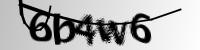

In [24]:
# 샘플 이미지 출력
img = cv2.imread(data_list[0], cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)

In [39]:
def preprocess_image(image,data_height = 50,data_width = 200,n_channel = 1):
  image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0) # 뒷배경을 제거
  # image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, np.ones((4,1), np.uint8))
  # image = cv2.dilate(image, np.ones((2,2), np.uint8), iterations = 1)
  # image = cv2.GaussianBlur(image, (1,1), 0)
  image = np.reshape(image, (data_height, data_width, n_channel)) / 255   # 모델 학습을 위해 0 - 1 사이의 값으로 스케일링
  return image

In [40]:
img = preprocess_image(img)
cv2_imshow(img * 255)

error: ignored

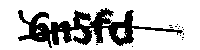

['6' 'n' '5' 'f' 'd']
(1039, 50, 200, 1)


In [41]:
# 이미지 크기, 채널
data_height = 50
data_width = 200
n_channel = 1

images = np.zeros((len_data, data_height, data_width, n_channel))
label = np.empty((len_data, 5), dtype = str)
characters = []

# 이미지 전처리와 글자 파싱
for n, path in enumerate(data_list):
  image = cv2.imread(data_list[n], cv2.IMREAD_GRAYSCALE)
  image = preprocess_image(image)
  images[n, :, :, :] = image
  path = path.split('/')[2]
  path = path.split('.')[0]
  path = list(path)
  label[n] = np.array(path)
  for i in range(5):
    characters.append(path[i])

cv2_imshow(images[3] * 255)
print(label[3])
print(images.shape)

In [42]:
from string import ascii_lowercase, digits

# 글자 종류 확인
characters = list(set(characters))
characters.sort()
print(characters)

['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


(1039, 5)
[263, 267, 284, 281, 259, 257, 263, 239, 262, 259, 235, 271, 271, 275, 525, 253, 235, 264, 232]


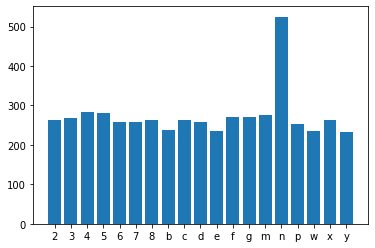

In [43]:
import matplotlib.pyplot as plt

# 라벨링
def char_to_num(num):
  if num in characters:
    return characters.index(num)
  return None

character_num = [0] * len(characters)

print(label.shape)
for i in range(len(label)):
  for j in range(len(label[0])):
    character_num[char_to_num(label[i,j])] += 1
print(character_num)

x = np.arange(len(characters))
plt.bar(x, character_num)
plt.xticks(x, characters)

plt.show()

In [44]:
# 원핫인코딩    
num_label = np.empty((5, len_data, len(characters)), dtype = int)
for i in range(len_data):
  targs = np.zeros((5, len(characters)))
  for j, l in enumerate(label[i]):
    ind = char_to_num(l)
    targs[j, ind] = 1
    num_label[:, i] = targs

print(num_label[3][3])

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]


In [45]:
import random

index_list = np.arange(len_data)
random.shuffle(index_list)
print(index_list)

# train, test split by random index
for i in range(len_data):
  train_X, test_X = images[index_list[:900]], images[index_list[900:]]
  train_y, test_y = num_label[:,index_list[:900]], num_label[:,index_list[900:]]

print(len(train_X),len(test_X))
print(train_X.shape)
print(len(train_y[0]),len(test_y[0]))
print(train_y[3])

[507 684 403 ... 251 860 599]
900 139
(900, 50, 200, 1)
900 139
[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]


In [46]:
from tensorflow import keras
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras import layers

In [58]:
def build_model(num_classes):
    img = layers.Input(shape=(50, 200, 1)) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (4, 4), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="valid")(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (4, 4), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (4, 4), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="valid")(bn)  # 25x7
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_classes, activation='sigmoid')(drop)
        outs.append(res)
    
    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [59]:
num_classes = len(characters)
model = build_model(num_classes)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 50, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 50, 200, 16)  272         ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 25, 100, 16)  0          ['conv2d_9[0][0]']               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 25, 100, 32)  8224        ['max_pooling2d_9[0][0]']  

In [49]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier

# batch size epoch grid search
batch_size = [10, 20, 40, 60, 80, 100, 200]
epochs = [10, 50, 100]

model_loses = []
cycle = len(batch_size) * len(epochs)
idx = 0 

for batchSize in batch_size:
  for epoch in epochs:
    print(f'{idx}/{cycle}')
    hist = model.fit(train_X, [train_y[0], train_y[1], train_y[2], train_y[3], train_y[4]], batch_size=batchSize, epochs=epoch,verbose=1, validation_split=0.2)
    model_loses.append(hist.history)
    idx += 1

0/21
Epoch 1/10
72/72 [==============================] - 2s 22ms/step - loss: 0.8402 - dense_31_loss: 0.1612 - dense_33_loss: 0.1057 - dense_35_loss: 0.1712 - dense_37_loss: 0.2065 - dense_39_loss: 0.1956 - dense_31_accuracy: 0.9347 - dense_33_accuracy: 0.9653 - dense_35_accuracy: 0.9347 - dense_37_accuracy: 0.9333 - dense_39_accuracy: 0.9264 - val_loss: 2.6746 - val_dense_31_loss: 0.0409 - val_dense_33_loss: 0.5361 - val_dense_35_loss: 1.0028 - val_dense_37_loss: 0.7190 - val_dense_39_loss: 0.3758 - val_dense_31_accuracy: 0.9889 - val_dense_33_accuracy: 0.9333 - val_dense_35_accuracy: 0.8667 - val_dense_37_accuracy: 0.8333 - val_dense_39_accuracy: 0.9278
Epoch 2/10
72/72 [==============================] - 2s 21ms/step - loss: 0.9292 - dense_31_loss: 0.1314 - dense_33_loss: 0.1787 - dense_35_loss: 0.2003 - dense_37_loss: 0.1889 - dense_39_loss: 0.2298 - dense_31_accuracy: 0.9472 - dense_33_accuracy: 0.9528 - dense_35_accuracy: 0.9375 - dense_37_accuracy: 0.9347 - dense_39_accuracy: 0.9

In [60]:
# model.fit(train_X, [train_y[0],train_y[1],train_y[2],train_y[3],train_y[4]], epochs=10, batch_size=200, verbose=2,validation_split=0.2)
hist = model.fit(train_X, [train_y[0], train_y[1], train_y[2], train_y[3], train_y[4]], batch_size=32, epochs=100,verbose=0, validation_split=0.2)

In [62]:
print("Train data accuracy")
print("dense 1:",hist.history["dense_31_accuracy"][99])
print("dense 3:",hist.history["dense_33_accuracy"][99])
print("dense 5:",hist.history["dense_35_accuracy"][99])
print("dense 7:",hist.history["dense_37_accuracy"][99])
print("dense 9:",hist.history["dense_39_accuracy"][99])

print("\nValidation data accuracy")
print("dense 1:",hist.history["val_dense_31_accuracy"][99])
print("dense 3:",hist.history["val_dense_33_accuracy"][99])
print("dense 5:",hist.history["val_dense_35_accuracy"][99])
print("dense 7:",hist.history["val_dense_37_accuracy"][99])
print("dense 9:",hist.history["val_dense_39_accuracy"][99])

Train data accuracy
dense 1: 0.9541666507720947
dense 3: 0.9638888835906982
dense 5: 0.9555555582046509
dense 7: 0.9444444179534912
dense 9: 0.9263888597488403

Validation data accuracy
dense 1: 0.9944444298744202
dense 3: 0.9277777671813965
dense 5: 0.8666666746139526
dense 7: 0.8500000238418579
dense 9: 0.9055555462837219


In [ ]:
def predict_x(img):
    img = np.reshape(img, (1, 50, 200, 1))
    res = np.array(model.predict(img))
    ans = np.reshape(res, (5, num_classes))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += characters[l]
    return capt#, sum(probs) / 5

In [ ]:
def print_y(y_list):
  result = ""
  for y in y_list:
    for i in range(len(y)):
      if int(y[i]) == 1:
        result += characters[i]
  return result

In [ ]:
print(predict_x(test_X[0]))
print(print_y([test_y[0][0], test_y[1][0], test_y[2][0], test_y[3][0], test_y[4][0]]))

1/1 [==============================] - 0s 170ms/step
4cfw8
4cfw8


In [ ]:
count = 0
for i in range(len(train_X)):
  if predict_x(train_X[i]) != print_y([train_y[0][i], train_y[1][i], train_y[2][i], train_y[3][i], train_y[4][i]]):
    count += 1

print((len(train_X)-count)/len(train_X))
print(len(train_X))

1/1 [==============================] - 0s 14ms/step
0.9033333333333333
900


In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
count = 0
y_pred = []
y_true = []
index = []

for i in range(len(train_X)):
  predictresult = predict_x(train_X[i])
  realresult = print_y([train_y[0][i], train_y[1][i], train_y[2][i], train_y[3][i], train_y[4][i]])
  for j in range(len(predictresult)):
    y_pred.append(predictresult[j])
    y_true.append(realresult[j]) 
    if (predictresult[j] == "m") and (realresult[j] == "n"):
      index.append(i)

print("n을 m으로 misclassification: " + str(len(index)))

1/1 [==============================] - 0s 22ms/step
p를 b로 misclassification: 20


0.9742222222222222
0.9757576109988877
0.975403966140322
0.9757576109988877
0.9754867416289564
(19, 19)


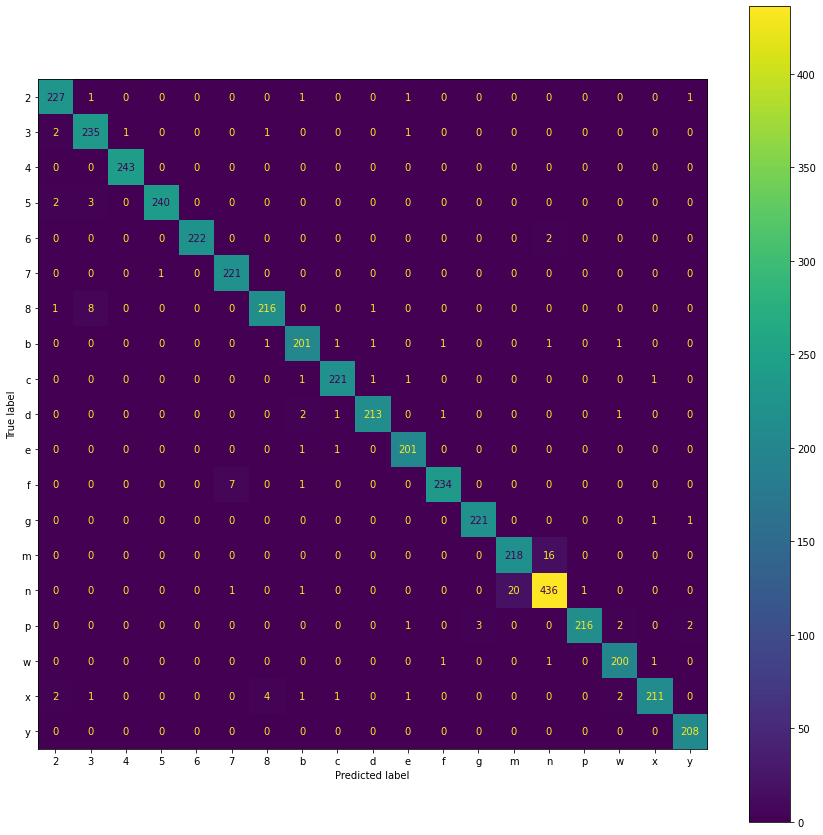

In [ ]:
print(metrics.accuracy_score(y_true, y_pred)) 
print(metrics.balanced_accuracy_score(y_true, y_pred)) 
print(metrics.precision_score(y_true, y_pred,average="macro"))
print(metrics.recall_score(y_true, y_pred,average="macro"))
print(metrics.f1_score(y_true, y_pred,average="macro")) 

conf_mat = metrics.confusion_matrix(y_true, y_pred) 
print(conf_mat.shape)
conf_dis = metrics.ConfusionMatrixDisplay(conf_mat, display_labels=characters)
fig, ax = plt.subplots(figsize=(15, 15))
conf_dis.plot(ax = ax)

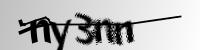

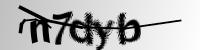

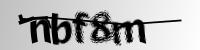

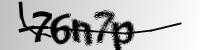

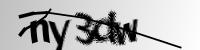

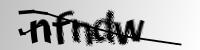

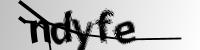

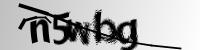

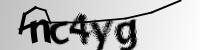

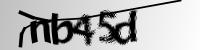

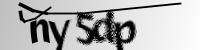

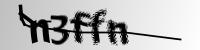

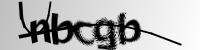

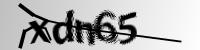

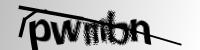

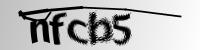

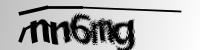

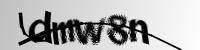

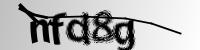

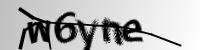

In [ ]:
# p를 b로 misclassification한 경우
for i in range(len(index)):
  cv2_imshow(train_X[index[i]] * 255)